In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [2]:
from pathlib import Path

data_path = Path("data")
image_path = data_path / "war_events"
train_dir = image_path / "train_real"
validation_dir = image_path / "test_real"

train_dir, validation_dir
output_dir = 'output'

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 275 files belonging to 5 classes.


In [4]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 125 files belonging to 5 classes.


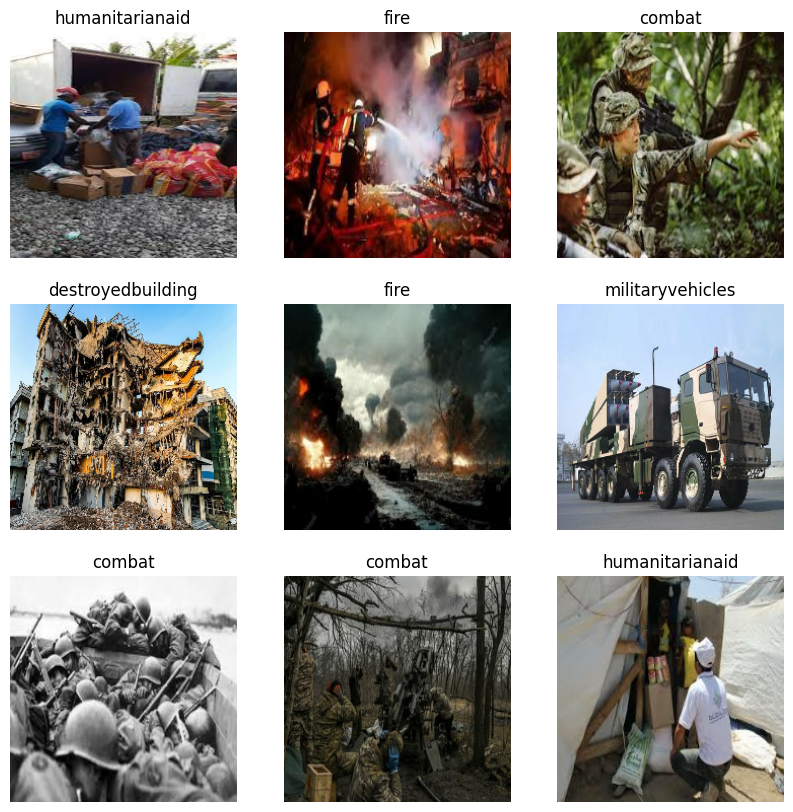

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
# efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"


In [7]:
# def create_model(model_url, num_classes=5):
#   """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
#   Args:
#     model_url (str): A TensorFlow Hub feature extraction URL.
#     num_classes (int): Number of output neurons in output layer,
#       should be equal to number of target classes, default 10.

#   Returns:
#     An uncompiled Keras Sequential model with model_url as feature
#     extractor layer and Dense output layer with num_classes outputs.
#   """
#   # Download the pretrained model and save it as a Keras layer
#   feature_extractor_layer = hub.KerasLayer(model_url,
#                                            trainable=True, # freeze the underlying patterns
#                                            name='feature_extraction_layer',
#                                            input_shape=IMG_SIZE+(3,)) # define the input image shape
  
#   # Create our own model
#   model = tf.keras.Sequential([
#     feature_extractor_layer, # use the feature extraction layer as the base
#     layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
#   ])

#   return model

In [8]:
# resnet_model = create_model(efficientnet_url, num_classes=5)

# # Compile
# resnet_model.compile(loss='sparse_categorical_crossentropy',
#                      optimizer=tf.keras.optimizers.SGD(),
#                      metrics=['accuracy'])

In [9]:
# Fit the model
# resnet_history = resnet_model.fit(train_dataset,
#                                   epochs=100,
#                                   steps_per_epoch=len(train_dataset),
#                                   validation_data=validation_dataset,
#                                   validation_steps=len(validation_dataset))

In [10]:
# resnet_model.save("eff", save_format='tf')

In [11]:
# resnet_model.save("eff.tf")

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

In [13]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
])

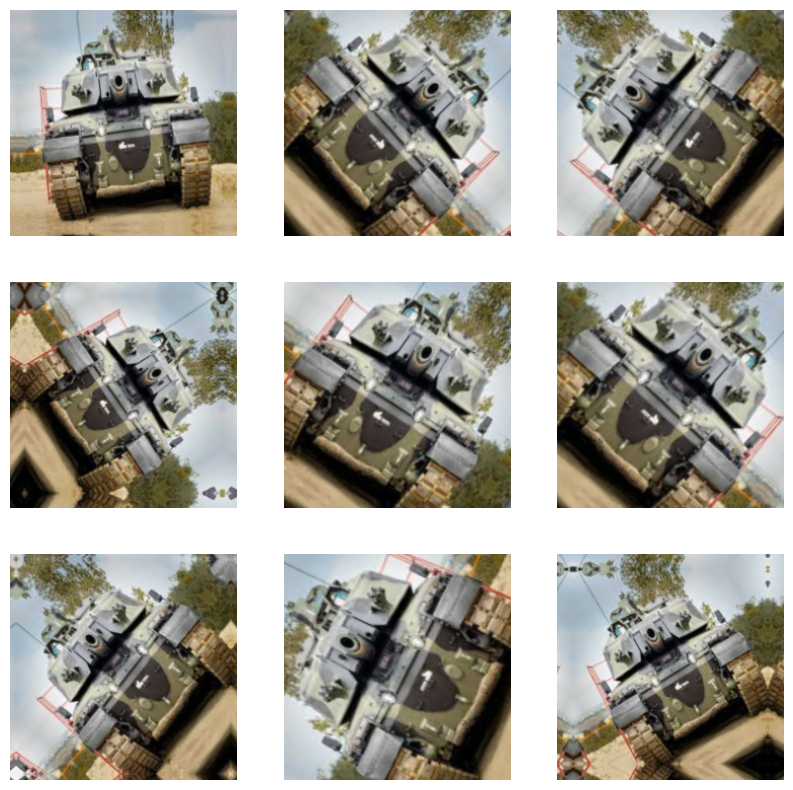

In [14]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [15]:
# preprocess_input = tf.keras.applications.resnet_v2.preprocess_input
preprocess_input = tf.keras.applications.efficientnet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [16]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetV2S(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

82420632/82420632 [==============================] - 15s 0us/step


In [17]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [18]:
base_model.trainable = False

In [19]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [20]:
prediction_layer = tf.keras.layers.Dense(5)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 5)


In [21]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=True)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [22]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

In [23]:
initial_epochs = 44

In [24]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/44
9/9 [==============================] - 41s 3s/step - loss: 1.6607 - accuracy: 0.2109 - val_loss: 1.5790 - val_accuracy: 0.2880
Epoch 2/44
9/9 [==============================] - 25s 3s/step - loss: 1.6123 - accuracy: 0.2327 - val_loss: 1.5467 - val_accuracy: 0.3440
Epoch 3/44
9/9 [==============================] - 25s 3s/step - loss: 1.6108 - accuracy: 0.2182 - val_loss: 1.5350 - val_accuracy: 0.2880
Epoch 4/44
9/9 [==============================] - 25s 3s/step - loss: 1.5389 - accuracy: 0.3127 - val_loss: 1.4909 - val_accuracy: 0.4080
Epoch 5/44
9/9 [==============================] - 25s 3s/step - loss: 1.5766 - accuracy: 0.2764 - val_loss: 1.4400 - val_accuracy: 0.4160
Epoch 6/44
9/9 [==============================] - 25s 3s/step - loss: 1.5319 - accuracy: 0.2909 - val_loss: 1.4253 - val_accuracy: 0.4240
Epoch 7/44
9/9 [==============================] - 25s 3s/step - loss: 1.4930 - accuracy: 0.3273 - val_loss: 1.4486 - val_accuracy: 0.4080
Epoch 8/44
9/9 [==================

In [25]:
base_model.trainable = True

In [26]:
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  513


In [27]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/25),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

In [28]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [29]:
fine_tune_epochs = 44
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks=es)

Epoch 44/88
9/9 [==============================] - 95s 8s/step - loss: 1.3091 - accuracy: 0.5564 - val_loss: 1.1160 - val_accuracy: 0.7360
Epoch 45/88
9/9 [==============================] - 69s 8s/step - loss: 1.0221 - accuracy: 0.7455 - val_loss: 0.9218 - val_accuracy: 0.8160
Epoch 46/88
9/9 [==============================] - 73s 8s/step - loss: 0.8819 - accuracy: 0.8218 - val_loss: 0.7945 - val_accuracy: 0.8480
Epoch 47/88
9/9 [==============================] - 63s 7s/step - loss: 0.7084 - accuracy: 0.8909 - val_loss: 0.6840 - val_accuracy: 0.8640
Epoch 48/88
9/9 [==============================] - 62s 7s/step - loss: 0.5992 - accuracy: 0.8945 - val_loss: 0.5857 - val_accuracy: 0.9360
Epoch 49/88
9/9 [==============================] - 62s 7s/step - loss: 0.4730 - accuracy: 0.9382 - val_loss: 0.4282 - val_accuracy: 0.9680
Epoch 50/88
9/9 [==============================] - 62s 7s/step - loss: 0.3742 - accuracy: 0.9455 - val_loss: 0.4094 - val_accuracy: 0.9440
Epoch 51/88
9/9 [==========

In [ ]:
# model.save()

In [32]:
# model.save("one96.h5") # 9/9 [==============================] - 208s 25s/step - loss: 0.0238 - accuracy: 1.0000 - val_loss: 0.1028 - val_accuracy: 0.9600

C:\Users\adity\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [31]:
# import tensorflow as tf

# # Assuming 'model' is your model
# tf.saved_model.save(model, "data\war_events")

In [46]:
history_even_more_fine = model.fit(train_dataset,
                         epochs=44,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 44/44


9/9 [==============================] - 68s 8s/step - loss: 0.0168 - accuracy: 1.0000 - val_loss: 0.0757 - val_accuracy: 0.9920


In [47]:
# model.save("bruh99.keras")
# model.save_weights("bruh99_weights.keras")